<a href="https://colab.research.google.com/github/Himakar06/customers_segmentation/blob/main/notebooks/Mall_cusotmers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram

In [78]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [79]:
print("Shape: ",df.shape)
print(df.columns)

Shape:  (200, 5)
Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')


In [80]:
#drop irrelevant columns
df.drop(columns='CustomerID',inplace=True)

In [81]:
#Encode categorical variables
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


In [82]:
#Scale numerical data
num_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
df_scaled = df.copy()

scaler = StandardScaler()
df_scaled[num_columns] = scaler.fit_transform(df_scaled[num_columns])

In [83]:
df_scaled.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,-1.424569,-1.738999,-0.434801
1,1,-1.281035,-1.738999,1.195704
2,0,-1.352802,-1.700830,-1.715913
3,0,-1.137502,-1.700830,1.040418
4,0,-0.563369,-1.662660,-0.395980


In [84]:
#Outlier detection
def detect_outlier(df,column):
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1-1.5*IQR
  upper_bound = Q3+1.5*IQR
  outliers = df[(df[column]<lower_bound) | (df[column]>upper_bound)]
  return outliers, lower_bound, upper_bound

outliers_indices = {}
for col in num_columns:
  outliers, lb, ub = detect_outlier(df,col)
  outliers_indices[col] = {
      'count' : len(outliers),
      'lower bound' : lb,
      'upper bound' : ub
  }
  print(f"{col}- Outliers : {len(outliers)}")

Age- Outliers : 0
Annual Income (k$)- Outliers : 2
Spending Score (1-100)- Outliers : 0


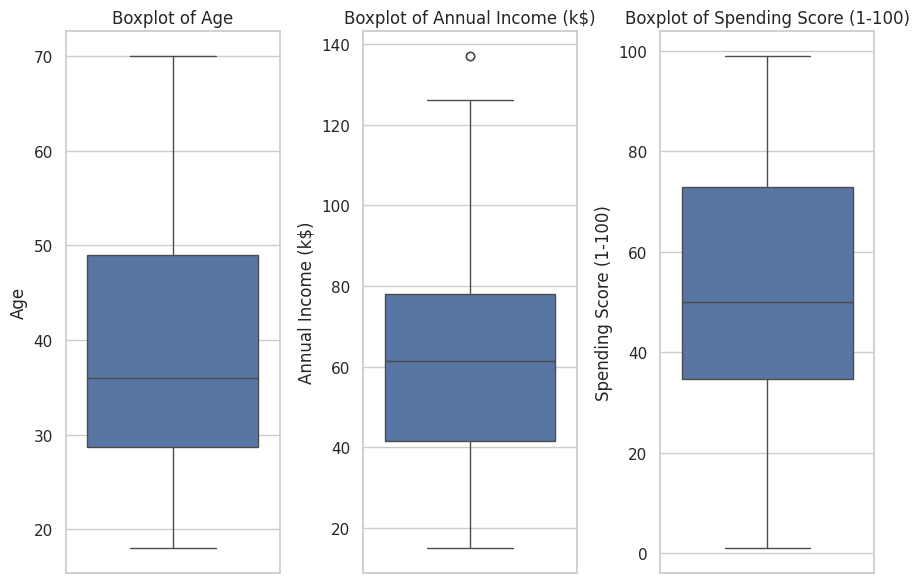

In [85]:
#Boxplots to identify spread and outliers
plt.figure(figsize=(9,6))

for i,col in enumerate(num_columns,1):
  plt.subplot(1,3,i)
  sns.boxplot(data=df, y=col)
  plt.title(f'Boxplot of {col}')
  plt.tight_layout()

plt.show()

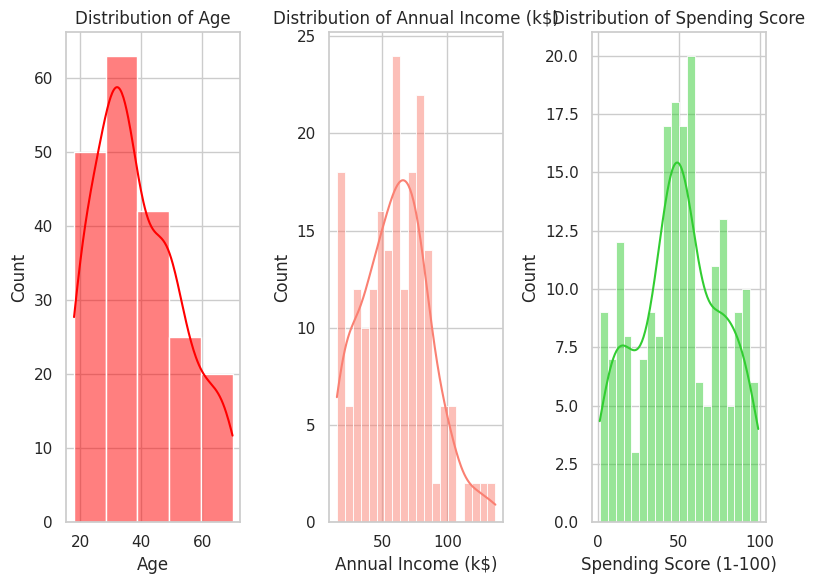

In [86]:
#distributions of Age, Annual Income, Spending Score
plt.figure(figsize=(8,6))

#Age distribution
plt.subplot(1,3,1)
sns.histplot(df['Age'], kde=True, bins=5, color = 'red')
plt.title('Distribution of Age')
plt.xlabel('Age')

# Annual Income distribution
plt.subplot(1, 3, 2)
sns.histplot(df['Annual Income (k$)'], kde=True, bins=20, color='salmon')
plt.title('Distribution of Annual Income (k$)')
plt.xlabel('Annual Income (k$)')

# Spending Score distribution
plt.subplot(1, 3, 3)
sns.histplot(df['Spending Score (1-100)'], kde=True, bins=20, color='limegreen')
plt.title('Distribution of Spending Score')
plt.xlabel('Spending Score (1-100)')

plt.tight_layout()
plt.show()

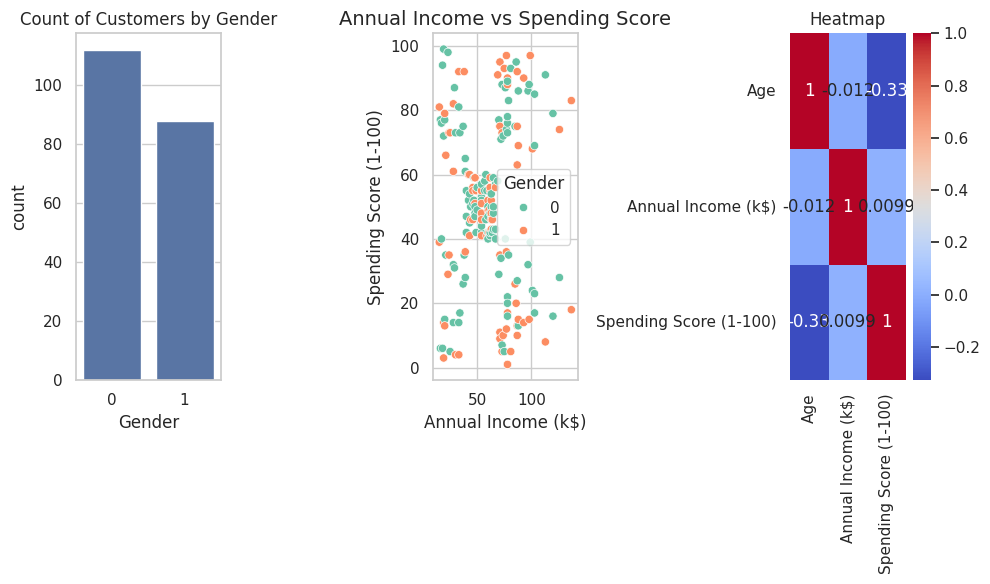

In [87]:
plt.figure(figsize=(10,6))

#Countplot for Gender
plt.subplot(1,3,1)
sns.countplot(x='Gender', data=df)
plt.title('Count of Customers by Gender')

#Scatterplots of Annual Income vs Spending Score
plt.subplot(1,3,2)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, hue='Gender', palette='Set2')
plt.title('Annual Income vs Spending Score', fontsize=14)
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Gender')

#correlation
corr_features = df[num_columns].corr()
plt.subplot(1,3,3)
sns.heatmap(data=corr_features, cmap='coolwarm', annot=True)
plt.title("Heatmap")

plt.tight_layout()
plt.show()

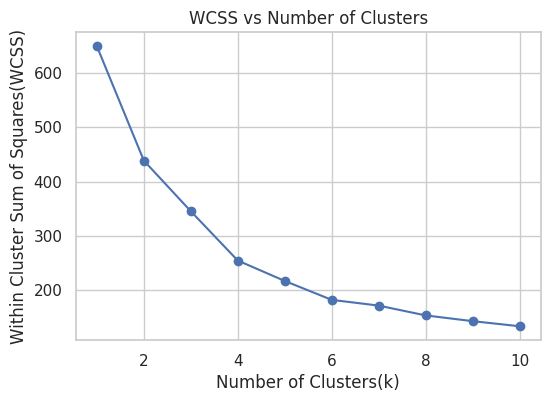

In [88]:
#K-Means clustering
wcss = []
k_range = range(1,11)

for k in k_range:
  kmeans = KMeans(n_clusters=k,random_state=42)
  kmeans.fit((df_scaled))
  wcss.append(kmeans.inertia_)

#Plot WCSS vs Number of Clusters
plt.figure(figsize=(6,4))
plt.plot(k_range, wcss, marker='o', linestyle='-', color='b')
plt.title('WCSS vs Number of Clusters')
plt.xlabel("Number of Clusters(k)")
plt.ylabel('Within Cluster Sum of Squares(WCSS)')
plt.show()

In [89]:
pip install kneed


In [90]:
from kneed import KneeLocator

kneedle = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")
optimal_k = kneedle.elbow
print(f"Optimal number of clusters: {optimal_k}")


Optimal number of clusters: 4


In [91]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels  = kmeans.fit_predict(df_scaled)
df['cluster'] = cluster_labels
df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,19,15,39,2
1,1,21,15,81,4
2,0,20,16,6,2
3,0,23,16,77,4
4,0,31,17,40,2


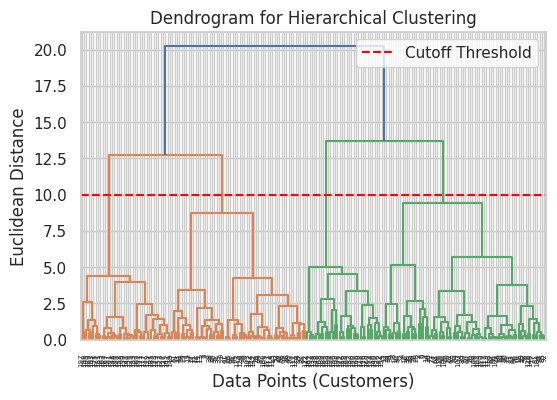

In [92]:
#Hierarchical Clustering
linkage_matrix = linkage(df_scaled, method='ward')

plt.figure(figsize=(6,4))
dendrogram(linkage_matrix)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Data Points (Customers)')
plt.ylabel('Euclidean Distance')
plt.axhline(y=10, color='red', linestyle='--', label='Cutoff Threshold')
plt.legend()
plt.show()

In [93]:
#Agglomerative clustering
agglo = AgglomerativeClustering(n_clusters=4,linkage='ward')
agglo_labels = agglo.fit_predict(df_scaled)
df['Agglo_cluster'] = agglo_labels
df.head()

# Compare counts
print("KMeans Cluster Counts:")
print(df['cluster'].value_counts().sort_index())

print("\nAgglomerative Cluster Counts:")
print(df['Agglo_cluster'].value_counts().sort_index())

KMeans Cluster Counts:
cluster
0    58
1    39
2    47
3    34
4    22
Name: count, dtype: int64

Agglomerative Cluster Counts:
Agglo_cluster
0    70
1    58
2    33
3    39
Name: count, dtype: int64


In [94]:
#DBSCAN
dbscan  = DBSCAN(eps=0.9, min_samples=5)
db_labels = dbscan.fit_predict(df_scaled)
df['DBSCAN_clusters'] = db_labels
df.head()
print(df['DBSCAN_clusters'].value_counts().sort_index())


DBSCAN_clusters
-1     13
 0     77
 1    110
Name: count, dtype: int64


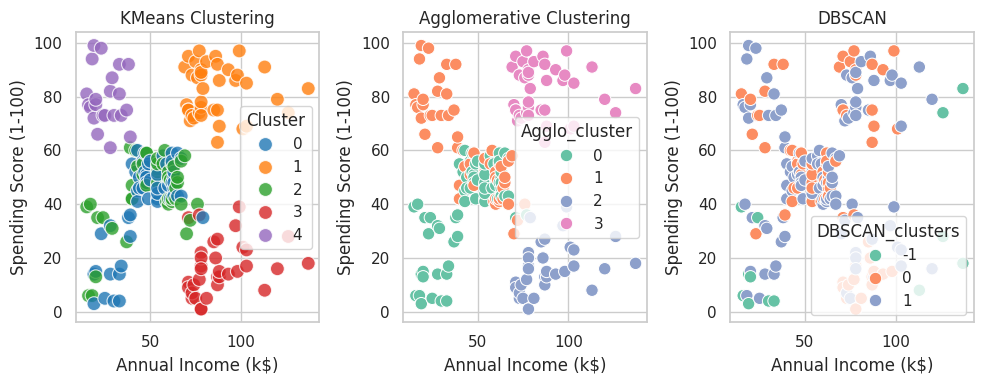

In [95]:
#Visulaize k-Means clusters
#Annual Income vs Spending Score
plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue = 'cluster', data=df, palette='tab10', alpha=0.8 , s=100)
plt.title('KMeans Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)

#Agglomerative Clustering
plt.subplot(1,3,2)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='Agglo_cluster', data=df, palette='Set2', s=80)
plt.title('Agglomerative Clustering')

#DBSCAN
plt.subplot(1,3,3)
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', hue='DBSCAN_clusters', data=df, palette='Set2', s=80)
plt.title('DBSCAN')

plt.tight_layout()
plt.show()


In [96]:
#Group data by Cluster and compute mean statistics
clusters_list = ['cluster', 'Agglo_cluster','DBSCAN_clusters']
print(clusters_list)
req = input("Enter the cluster to get the respective summary :\n ").strip()
if req in clusters_list:
  cluster_summary = df.groupby(df[req])[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2).sort_index()
  print(f"{req} summary :\n ", cluster_summary)

  print("Cluster Interpretation: \n")
  for cluster_id, row in cluster_summary.iterrows():
    age = row['Age']
    income = row['Annual Income (k$)']
    score = row['Spending Score (1-100)']

    #Gender-wise insights
    gender_counts = df[df[req]==cluster_id]['Gender'].value_counts(normalize=True).map(lambda x : round(x*100, 1))
    male_pct = gender_counts.get(1, 0.0)
    female_pct = gender_counts.get(0, 0.0)

    if income > 70 and score > 60:
      label = " Premium Customers"
    elif income < 40 and score > 60:
      label = " Budget Shoppers"
    elif income > 70 and score < 40:
      label = " High Income, Low Spending (Potential Upsell)"
    elif income < 40 and score < 40:
      label = " Low Value Segment"
    else:
      label = " Mid-Tier Customers"

    #Old vs Young
    age_group = "Young" if age<30 else("Middle-aged" if age <50 else 'Older')

    #Loyalty potential
    if score > 70:
      loyalty = "High Loyalty Potential"
    elif score > 40:
      loyalty = "Moderate Loyalty"
    else:
      loyalty = "Low Loyalty"

    print(f"-->Cluster {cluster_id}: {label}")
    print(f"  Average Age: {age:.1f} ({age_group})")
    print(f"  Average Income: {income:.1f}k")
    print(f"  Average Spending Score: {score:.1f} - {loyalty}")
    print(f"  Gender split: {male_pct}% | {female_pct}%\n")
else:
    print(f"\n❌ '{req}' is not a valid cluster label. Please choose from: {clusters_list}")

['cluster', 'Agglo_cluster', 'DBSCAN_clusters']
Enter the cluster to get the respective summary :
 cluster
cluster summary :
             Age  Annual Income (k$)  Spending Score (1-100)
cluster                                                   
0        55.55               48.48                   41.78
1        32.69               86.54                   82.13
2        27.96               50.00                   44.64
3        41.26               88.50                   16.76
4        25.27               25.73                   79.36
Cluster Interpretation: 

-->Cluster 0:  Mid-Tier Customers
  Average Age: 55.5 (Older)
  Average Income: 48.5k
  Average Spending Score: 41.8 - Moderate Loyalty
  Gender split: 43.1% | 56.9%

-->Cluster 1:  Premium Customers
  Average Age: 32.7 (Middle-aged)
  Average Income: 86.5k
  Average Spending Score: 82.1 - High Loyalty Potential
  Gender split: 46.2% | 53.8%

-->Cluster 2:  Mid-Tier Customers
  Average Age: 28.0 (Young)
  Average Income: 50.0k
  A

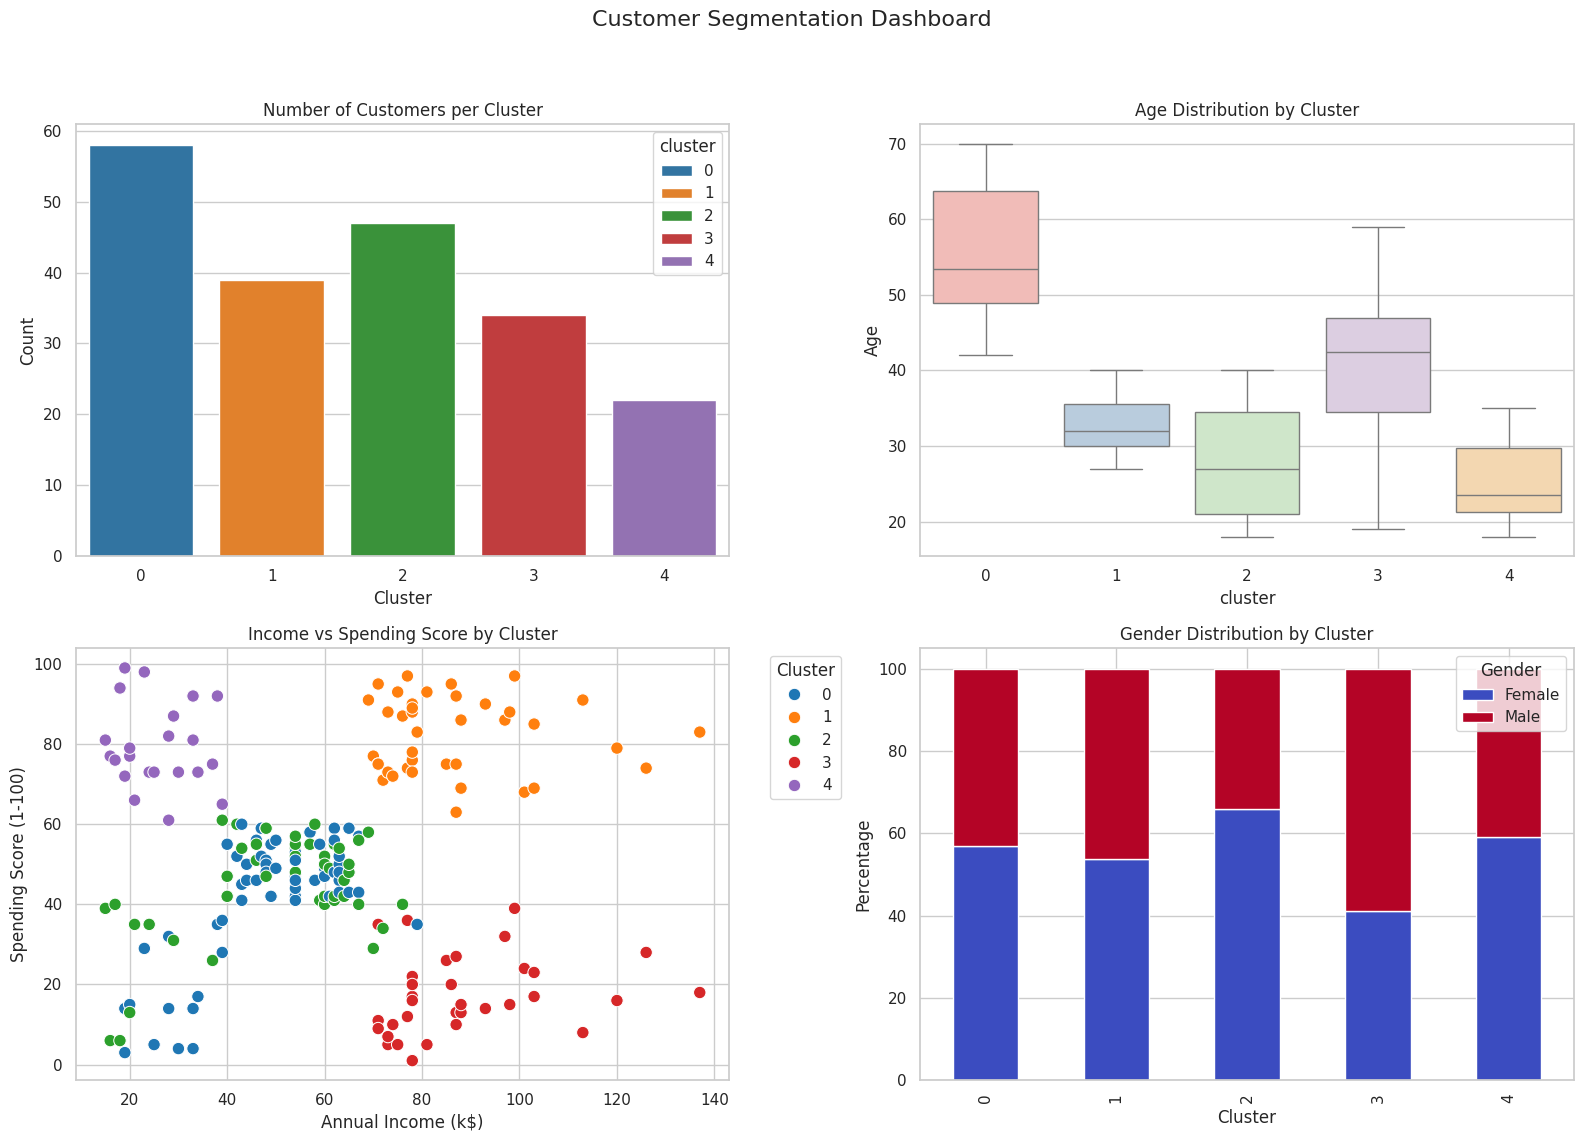

In [97]:
# Set figure
plt.figure(figsize=(16, 12))
sns.set(style="whitegrid")

# Plot 1: Cluster size
plt.subplot(2, 2, 1)
cluster_counts = df['cluster'].value_counts().sort_index()
sns.barplot(x=cluster_counts.index, y=cluster_counts.values,hue=cluster_counts.index, palette='tab10')
plt.title('Number of Customers per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Plot 2: Age Distribution by Cluster
plt.subplot(2, 2, 2)
sns.boxplot(x='cluster', y='Age', data=df, hue='cluster',palette='Pastel1', dodge=False, legend=False)
plt.title('Age Distribution by Cluster')

# Plot 3: Income vs Spending (Color = Cluster)
plt.subplot(2, 2, 3)
sns.scatterplot(
    x='Annual Income (k$)', y='Spending Score (1-100)',
    hue='cluster', palette='tab10', data=df, s=80
)
plt.title('Income vs Spending Score by Cluster')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 4: Gender Distribution by Cluster
plt.subplot(2, 2, 4)
gender_cluster = pd.crosstab(df['cluster'], df['Gender'], normalize='index') * 100
gender_cluster.plot(kind='bar', stacked=True, colormap='coolwarm', ax=plt.gca())
plt.title('Gender Distribution by Cluster')
plt.ylabel('Percentage')
plt.xlabel('Cluster')
plt.legend(title='Gender', labels=['Female', 'Male'])

plt.suptitle('Customer Segmentation Dashboard', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
